A Data-Driven Approach to Asymmetric Hydrogenation of Alkenes

Group 7: Zoe Zhang, Qi Wu, Yilun Li

Abstract:

The asymmetric hydrogenation reaction is one of the most crucial chiral construction methods in molecular synthesis, widely applied in the synthesis of pharmaceuticals and natural products. However, the lack of efficient predictive design strategies, combined with the variability of conditions required for different substrates, makes the development of asymmetric hydrogenation catalysts a time-consuming and costly process. To address this challenge, we built a database of approximately 2,000 asymmetric hydrogenation reactions from existing literature, extracting both quantum chemical and geometric descriptors of substrates and catalysts (all structures optimized via the XTB), along with their enantioselectivity. After applying principal component analysis and dimensionality reduction, we plan to employ a Bayesian Neural Network to build a regression model that uses these descriptors as features to predict enantioselectivity. Unlike conventional machine learning approaches based solely on traditional supervised learning, which only provides predictions, our Bayesian Neural Network model aims to predict the ee% values accurately while also providing confidence intervals for these predictions, enabling a more informed approach to catalyst screening and experimental design.


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold, cross_val_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import tensorflow_probability as tfp
import tf_keras


In [62]:
# Load data
df = pd.read_excel('reordered_final_merged_cleaned_qqm_molecule_charges.xlsx')

# Filter for Tri_Q4 subset
tri_q4_df = df[df['_Alkene_Type'] == 'Tri_Q4']

# Prepare features and target
X = tri_q4_df.drop(columns=['Rxn ID', 'Reactant ID', 'Catalyst ID', 'ddG', '_Alkene_Type', 'ee'])
X = X.loc[:, ~X.columns.str.contains('Q4')]  # Drop features containing 'Q4'
y = tri_q4_df['ddG']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)

(576, 21)


MC dropout model: Bayesian-like

In [ ]:
def build_mc_dropout_model(input_dim, dropout_rate=0.1):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dropout(dropout_rate)(x, training=True)  
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x, training=True)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

input_dim = X_train_scaled.shape[1]
model = build_mc_dropout_model(input_dim, dropout_rate=0.1)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train_scaled, y_train,
    epochs=100, batch_size=32,
    validation_split=0.2,
    verbose=0
)
def predict_with_uncertainty(model, x, n_iter=100):
    preds = np.zeros((n_iter, len(x)))
    for i in range(n_iter):
        preds[i] = model.predict(x, verbose=0).flatten()
    pred_mean = preds.mean(axis=0)
    pred_std = preds.std(axis=0)
    return pred_mean, pred_std

# Predict on training data
train_pred_mean, train_pred_std = predict_with_uncertainty(model, X_train_scaled, n_iter=100)
test_pred_mean, test_pred_std = predict_with_uncertainty(model, X_test_scaled, n_iter=100)

mae_train = mean_absolute_error(y_train, train_pred_mean)
r2_train = r2_score(y_train, train_pred_mean)
print(f"Train R²: {r2_train:.4f}, MAE: {mae_train:.4f}")

mae_test = mean_absolute_error(y_test, test_pred_mean)
r2_test = r2_score(y_test, test_pred_mean)
print(f"Test R²: {r2_test:.4f}, MAE: {mae_test:.4f}")

Train R²: 0.4770, MAE: 0.5559
Test R²: 0.4220, MAE: 0.5914


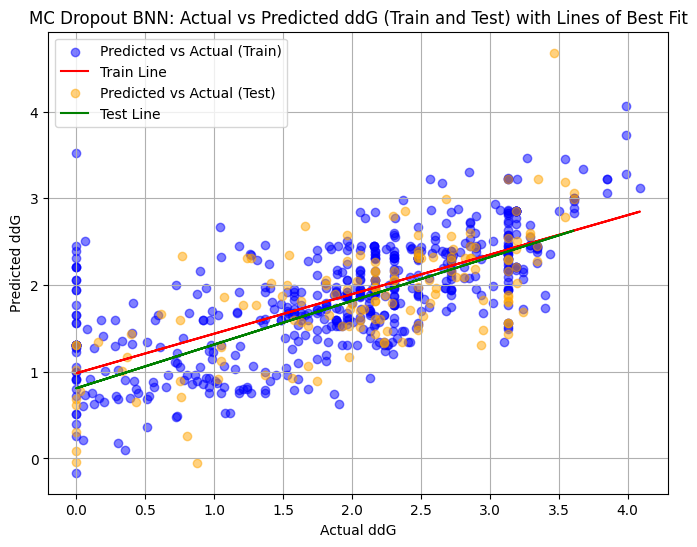

In [64]:
# Compute lines of best fit
slope_train, intercept_train = np.polyfit(y_train, train_pred_mean, 1)
slope_test, intercept_test = np.polyfit(y_test, test_pred_mean, 1)

# Plotting both train and test predictions
plt.figure(figsize=(8, 6))

# Training data
plt.scatter(y_train, train_pred_mean, color='blue', alpha=0.5, label='Predicted vs Actual (Train)')
plt.plot(y_train, slope_train * y_train + intercept_train, color='red', label=f'Train Line')

# Test data
plt.scatter(y_test, test_pred_mean, color='orange', alpha=0.5, label='Predicted vs Actual (Test)')
plt.plot(y_test, slope_test * y_test + intercept_test, color='green', label=f'Test Line')

plt.xlabel('Actual ddG')
plt.ylabel('Predicted ddG')
plt.title('MC Dropout BNN: Actual vs Predicted ddG (Train and Test) with Lines of Best Fit')
plt.legend()
plt.grid(True)
plt.show()
